In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#importing libraries
import numpy as np 
import matplotlib.pyplot as plt
import random

import os #for operating system dependent fucntionality
from keras import layers #for building layers of neural net
from keras.models import Model
from keras.models import load_model
from keras import callbacks #for training logs, saving to disk periodically
import cv2 #OpenCV(Open Source computer vision lib), containg CV algos
import string

import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from collections import Counter

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences
# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
dir = "/content/drive/MyDrive/CSE422 lab/422 Project/captcha_images"
os.listdir(dir)[:10]

['X59V.png',
 'X53F.png',
 'X59Y.png',
 'X5G8.png',
 'X5RZ.png',
 'X5YV.png',
 'X63X.png',
 'X6BC.png',
 'X6CC.png',
 'X6EW.png']

In [ ]:
#total no of images in dataset
n=len(os.listdir(dir))
n

9953

In [ ]:
#shuffled list of images to avoid having missing letter in train set
files_list = random.sample(os.listdir(dir), n)
files_list[:10]

['3HMA.png',
 'JD9R.png',
 '6JHB.png',
 'RZGB.png',
 'CEDZ.png',
 'SCHY.png',
 'E5KP.png',
 'NKG9.png',
 '6YFL.png',
 'FT5X.png']

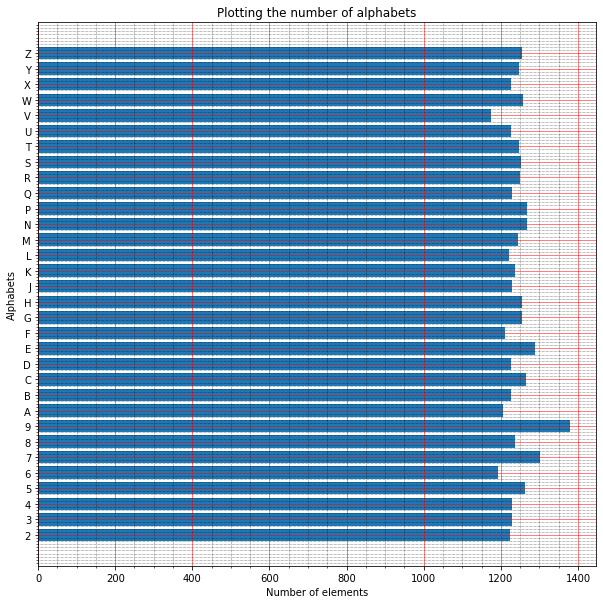

In [ ]:
labels = os.listdir(dir)

#number of each alphabets as a graph

letter = {}
for label in labels:
  for unit in label[:4]:
    if unit in letter:
      letter[unit] += 1
    else:
      letter[unit] = 1


alphabets, values = zip(*sorted(letter.items()))

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.barh(alphabets, values)
plt.xlabel("Number of elements")
plt.ylabel("Alphabets")
plt.title("Plotting the number of alphabets")
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
#defining size of image
imgshape=(24,72,1) #24-height, 72-width, 1-no of channels

In [ ]:
character= string.ascii_uppercase + "23456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

34

In [ ]:
#preprocesss image
def preprocess():
  X = np.zeros((n,24,72,1)) #9955*24*72 array with all entries 0
  y = np.zeros((4,n,nchar)) #4*9955*34(4 letters in captcha) with all entries 0

  for i, pic in enumerate(random.sample(os.listdir(dir), n)):
  #for i, pic in enumerate(os.listdir(dir)):
  #i represents index no. of image in directory 
  #pic contains the file name of the particular image to be preprocessed at a time
    
    img = cv2.imread(os.path.join(dir, pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale format
    pic_target = pic[:-4]#this drops the .png extension from file name and contains only the captcha for training
    
    if len(pic_target) < 5: #captcha is not more than 4 letters
      img = img / 255.0 #scales the image between 0 and 1
      img = np.reshape(img, (24, 72, 1)) #reshapes image to width 72 , height 24 ,channel 1 

      target=np.zeros((4,nchar)) #creates an array of size 4*34 with all entries 0

      for j, k in enumerate(pic_target):
      #j iterates from 0 to 3(4 letters in captcha)
      #k denotes the letter in captcha which is to be scanned
         index = character.find(k) #index stores the position of letter k of captcha in the character string
         target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

      X[i] = img #stores all the images
      y[:,i] = target #stores all the info about the letters in captcha of all images

  return X,y

In [ ]:
X,y=preprocess()

In [ ]:
#split the 7467 samples where 2488 samples will be used for training purpose
X_train, y_train = X[:7467], y[:, :7467]
X_test, y_test = X[7467:], y[:, 7467:]

In [ ]:
np.shape(X_train)

(7467, 24, 72, 1)

In [ ]:
np.shape(y_train)

(4, 7467, 34)

# **Model 1 (CNN with 24 layers)**



In [ ]:
#create model
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)  #24*72
    mp1 = layers.MaxPooling2D(padding='same')(conv1)   #12*36
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  #6*18
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)   #3*9
    
    flat = layers.Flatten()(mp3) #convert the layer into 1-D   

    outs = []
    for _ in range(4): #for 4 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(drop)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [ ]:
#Create model
model=createmodel();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 72, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 72, 16)   160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 12, 36, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 12, 36, 32)   4640        ['max_pooling2d[0][0]']          
                                                                                              

In [ ]:
#Applying the model
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3]], batch_size=32, epochs=20, validation_split=0.2)
#batch size- 32 defines no. of samples per gradient update
#Validation split=0.2 splits the training set in 80-20% for training nd testing

Epoch 1/20
187/187 [==============================] - 6s 12ms/step - loss: 14.0822 - dense_1_loss: 3.5137 - dense_3_loss: 3.5289 - dense_5_loss: 3.5296 - dense_7_loss: 3.5100 - dense_1_accuracy: 0.0335 - dense_3_accuracy: 0.0305 - dense_5_accuracy: 0.0315 - dense_7_accuracy: 0.0417 - val_loss: 14.0352 - val_dense_1_loss: 3.5121 - val_dense_3_loss: 3.5160 - val_dense_5_loss: 3.4992 - val_dense_7_loss: 3.5079 - val_dense_1_accuracy: 0.0576 - val_dense_3_accuracy: 0.0422 - val_dense_5_accuracy: 0.0355 - val_dense_7_accuracy: 0.0321
Epoch 2/20
187/187 [==============================] - 2s 8ms/step - loss: 12.9207 - dense_1_loss: 3.2591 - dense_3_loss: 3.2875 - dense_5_loss: 3.2192 - dense_7_loss: 3.1549 - dense_1_accuracy: 0.0737 - dense_3_accuracy: 0.0717 - dense_5_accuracy: 0.0810 - dense_7_accuracy: 0.0834 - val_loss: 12.3259 - val_dense_1_loss: 3.1085 - val_dense_3_loss: 3.1475 - val_dense_5_loss: 3.0650 - val_dense_7_loss: 3.0049 - val_dense_1_accuracy: 0.1473 - val_dense_3_accuracy: 

### Testing and Performance Graphs

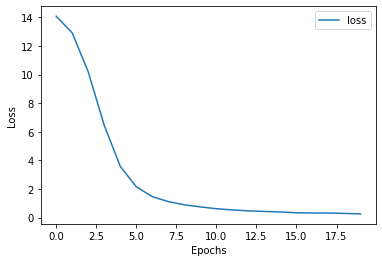

In [ ]:
#graph of loss vs epochs
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

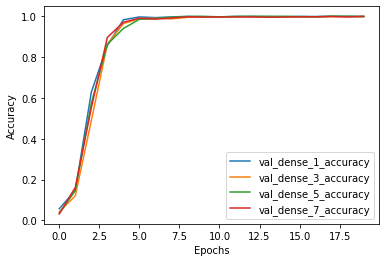

In [ ]:
#graph of accuracy of dense_2 vs epochs
for label in ["val_dense_1_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_3_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_5_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_7_accuracy"]:
  plt.plot(hist.history[label],label=label)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#Loss on training set
#Finding Loss on training set
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3]])
print ("Loss on training set= " + str(preds[0]))

234/234 [==============================] - 1s 5ms/step - loss: 0.0030 - dense_1_loss: 5.2331e-04 - dense_3_loss: 8.0319e-04 - dense_5_loss: 9.5993e-04 - dense_7_loss: 7.4620e-04 - dense_1_accuracy: 0.9999 - dense_3_accuracy: 0.9997 - dense_5_accuracy: 0.9996 - dense_7_accuracy: 0.9999
Loss on training set= 0.0030326293781399727


In [ ]:
#Finding loss on test set
preds = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3]])
print ("Loss on testing set= " + str(preds[0]))

78/78 [==============================] - 0s 5ms/step - loss: 0.0211 - dense_1_loss: 8.5276e-04 - dense_3_loss: 0.0064 - dense_5_loss: 0.0014 - dense_7_loss: 0.0124 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9988 - dense_5_accuracy: 0.9996 - dense_7_accuracy: 0.9964
Loss on testing set= 0.02107904851436615


In [ ]:
#to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None: #image foud at file path
        img = img / 255.0 #Scale image
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1 
    #added this bcoz x_train 7467*24*72*1
    #returns array of size 1*4*34
    result = np.reshape(res, (4, 34)) #reshape the array
    #result = res 
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    return capt 

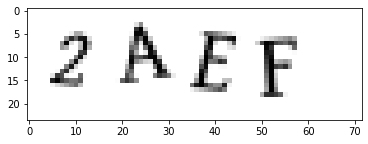

In [ ]:
#Sample 1
img=cv2.imread("/content/drive/MyDrive/CSE422 lab/422 Project/2AEF.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
print("Predicted Captcha =",predict("/content/drive/MyDrive/CSE422 lab/422 Project/2AEF.png"))

Predicted Captcha = 2AEF


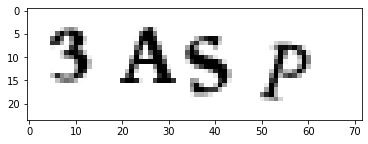

In [ ]:
#Sample 2
img=cv2.imread("/content/drive/MyDrive/CSE422 lab/422 Project/3ASP.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
print("Predicted Captcha =",predict("/content/drive/MyDrive/CSE422 lab/422 Project/3ASP.png"))

Predicted Captcha = 3ASP


# **MODEL 2 (RECURRENT NEURAL NETWORK)**

In [ ]:
char_list= list(alphabets)
max_label_len = 4
char_list

In [ ]:
# convert the words to array of indexs based on the char_list
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(alphabets.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst
    
encode_to_labels("2345ABCDE") 

[0, 1, 2, 3, 8, 9, 10, 11, 12]

In [ ]:
import glob
all_image_paths = glob.glob(os.path.join(dir, "*.png"))
all_image_paths = random.sample(all_image_paths, len(all_image_paths))
all_image_paths[:5]


['/content/drive/MyDrive/CSE422 lab/422 Project/captcha_images/8MX6.png',
 '/content/drive/MyDrive/CSE422 lab/422 Project/captcha_images/6ZEW.png',
 '/content/drive/MyDrive/CSE422 lab/422 Project/captcha_images/BVER.png',
 '/content/drive/MyDrive/CSE422 lab/422 Project/captcha_images/3ZZY.png',
 '/content/drive/MyDrive/CSE422 lab/422 Project/captcha_images/ZPMR.png']

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.2
train_image_paths, test_image_paths = train_test_split(all_image_paths, test_size=test_size, random_state=42)

In [ ]:
TIME_STEPS = 9
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

i=0
for train_img_path in train_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)

    # in this dataset, we don't need to do any resize at all here.
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.
    
    label = train_img_path[-8:-4]

    # split data into validation and training dataset as 10% and 90% respectively
    orig_txt.append(label)   
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label)) 
    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))

has processed trained 500 files
has processed trained 1000 files
has processed trained 1500 files
has processed trained 2000 files
has processed trained 2500 files
has processed trained 3000 files
has processed trained 3500 files
has processed trained 4000 files
has processed trained 4500 files
has processed trained 5000 files
has processed trained 5500 files
has processed trained 6000 files
has processed trained 6500 files
has processed trained 7000 files
has processed trained 7500 files


In [ ]:
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

for test_img_path in test_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)
    
    # in this dataset, we don't need to do any resize at all here.
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = test_img_path[-8:-4]

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed test {} files".format(i))

has processed test 500 files
has processed test 1000 files
has processed test 1500 files


In [ ]:
max_label_len = TIME_STEPS
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

In [ ]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=32 and width=128 
inputs = Input(shape=(24,72,1))
 
# convolution layer with kernel size (3,3)  #(24,72,64)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(12,36,64)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

#(12,36,128)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(6,18,128)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

#(6,18,256)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

# poolig layer with kernel size (2,2) to make the height/2  #(3,9,256)
pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

batch_norm_3 = BatchNormalization()(pool_3)

#(3,9,256)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)

# Batch normalization layer #(3,9,256)
batch_norm_5 = BatchNormalization()(conv_4)

#(3,9,512)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)

# poolig layer with kernel size (2,2) to make the height/2 #(1,9,512)
pool_6 = MaxPool2D(pool_size=(3, 1))(batch_norm_6)
 
# # to remove the first dimension of one: (1,9,512) -> (9,512)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_6)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 72, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 72, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 36, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 18, 128)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 18, 256)        2951

# **MODEL (3) : CONNECTIONIST TEMPORAL CLASSIFICATION**


In [ ]:
### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath='checkpoint_weights.hdf5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=15,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 72, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 24, 72, 64)   640         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 12, 36, 64)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 12, 36, 128)  73856       ['max_pooling2d_3[0][0]']        
                                                                                            

In [ ]:
# notice I convert everything to numpy array here since model can fit either tensors and numpy array
# the reason why i stick with numpy array because it is simple to code and also because it is baseline solution
# I want to use openCV (can't run with tensors because it is CPU operations)
# And if I want to use tensors then i will make sure my image preprocessing functions uses tensor compatible operations

# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our test data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

In [ ]:
# choose batchsize and epochs

batch_size = 32
epochs = 10

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

Epoch 1/10
248/249 [============================>.] - ETA: 0s - loss: 0.0405
Epoch 1: val_loss did not improve from 0.06627
249/249 [==============================] - 10s 39ms/step - loss: 0.0404 - val_loss: 8.3120 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - ETA: 0s - loss: 0.0039
Epoch 2: val_loss improved from 0.06627 to 0.04686, saving model to checkpoint_weights.hdf5
249/249 [==============================] - 10s 41ms/step - loss: 0.0039 - val_loss: 0.0469 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 0.0016
Epoch 3: val_loss improved from 0.04686 to 0.00817, saving model to checkpoint_weights.hdf5
249/249 [==============================] - 8s 33ms/step - loss: 0.0016 - val_loss: 0.0082 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - ETA: 0s - loss: 0.0078
Epoch 4: val_loss did not improve from 0.00817
249/249 [==============================] - 8s 33ms/step - loss: 0.0078 - val_loss: 23.2559 - lr: 0.0010

In [ ]:
NO_PREDICTS = 200
OFFSET=0
prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])

In [ ]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
all_predictions =[]
i = 0
for x in out:
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    all_predictions.append(pred)
    i+=1

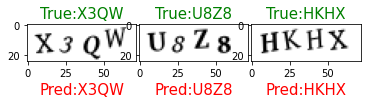

In [ ]:
# WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,100))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS//5, 5)
gs1.update(wspace=0.025, hspace=0.025)
for n in range(3):
    plt.subplot(gs1[n])
    plt.title("True:"+valid_orig_txt[n+OFFSET], fontsize=15, color="green")
    plt.imshow(valid_img[n][:,:,0], cmap="gray")
    plt.xlabel("Pred:"+all_predictions[n+OFFSET], fontsize=15, color="red")